In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the CSV file
data_path = 'U:/GitHub/AI-ethnicity-med-image/data/NLST_CT_withPID.csv'
df = pd.read_csv(data_path)

# Define the mapping for the selected categories
race_mapping = {
    1: "White",
    2: "Black or African-American",
    3: "Asian",
    4: "American Indian or Alaskan Native",
    5: "Native Hawaiian or Other Pacific Islander"
}

# Map the 'Patient Race' column to the corresponding strings
df['Patient Race'] = df['Patient Race'].map(race_mapping)

# Drop rows where 'Patient Race' is NaN (i.e., excluded categories)
df_cleaned = df.dropna(subset=['Patient Race'])

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# Ensure unique patients and handle multiple images by selecting one per patient
grouped = df_cleaned.groupby('Subject ID')
df_single_image_per_patient = grouped.apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# Convert 'Patient Race' to integer labels
label_mapping = {
    "White": 0,
    "Black or African-American": 1,
    "Asian": 2,
    "American Indian or Alaskan Native": 3,
    "Native Hawaiian or Other Pacific Islander": 4
}
df_single_image_per_patient['Race_Label'] = df_single_image_per_patient['Patient Race'].map(label_mapping)

# Sample a maximum number of images per patient (1 image per unique patient)
sampled_df = df_single_image_per_patient.sample(n=2000, random_state=42)

In [14]:
# Split data, maintaining class proportions
X_train, X_val, y_train, y_val = train_test_split(
    sampled_df['File Location'],
    sampled_df['Race_Label'],
    test_size=0.2,
    stratify=sampled_df['Race_Label'],
    random_state=42
)

In [15]:
current_path = os.getcwd()
print(current_path)

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [16]:
# Change to current directory
os.chdir(r'E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT')
print(os.getcwd())

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [17]:
# Apply data augmentation on minority classes to oversample
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [18]:
# Load and preprocess images
def preprocess_images(file_paths, labels):
    image_data = []
    processed_labels = []
    for file_path, label in zip(file_paths, labels):
        dicom_folder = file_path  # Path to folder containing DICOM images
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
        
        if dicom_files:
            dicom_path = os.path.join(dicom_folder, dicom_files[0])  # Use the first DICOM image for simplicity
            ds = pydicom.dcmread(dicom_path)
            img_array = ds.pixel_array / np.max(ds.pixel_array)  # Normalize
            img = Image.fromarray(img_array).resize((224, 224))  # Resize
            img_array_resized = np.array(img)

            # Convert to 3 channels
            img_array_resized = np.repeat(img_array_resized[..., np.newaxis], 3, axis=-1)

            # Augment for minority classes only
            if label != 0:  # Only augment if it's not the majority class (label 0 = "White")
                img_array_resized = datagen.random_transform(img_array_resized)
            
            image_data.append(img_array_resized)
            processed_labels.append(label)
    
    return np.array(image_data), np.array(processed_labels)

In [19]:
# Preprocess images for training and validation
X_train_images, y_train_labels = preprocess_images(X_train, y_train)
X_val_images, y_val_labels = preprocess_images(X_val, y_val)

In [20]:
# Define Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return focal_loss_fixed

In [42]:
# Define class weights with underweighting of the majority class
class_weights = {
    0: 0.1,  # Majority class: White
    1: 2.0,  # Black or African-American
    2: 3.0,  # Asian
    3: 15.0,  # American Indian or Alaskan Native
    4: 15.0   # Native Hawaiian or Other Pacific Islander
}

In [44]:
from sklearn.metrics import balanced_accuracy_score, f1_score

# Custom balanced accuracy metric
def balanced_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=1)

    # Convert to numpy arrays
    y_true_np = y_true.numpy()
    y_pred_np = y_pred.numpy()

    # Identify classes present in y_true and filter out any others from y_pred
    unique_classes = np.unique(y_true_np)
    mask = np.isin(y_pred_np, unique_classes)
    y_true_filtered = y_true_np[mask]
    y_pred_filtered = y_pred_np[mask]

    # Compute balanced accuracy using sklearn
    if len(np.unique(y_true_filtered)) > 1:  # Only compute if more than one class remains
        return balanced_accuracy_score(y_true_filtered, y_pred_filtered)
    else:
        return np.nan  # Return NaN if balanced accuracy can't be computed

# Custom macro F1-score metric
def macro_f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=1)

    # Convert to numpy arrays
    y_true_np = y_true.numpy()
    y_pred_np = y_pred.numpy()

    # Identify classes present in y_true and filter out any others from y_pred
    unique_classes = np.unique(y_true_np)
    mask = np.isin(y_pred_np, unique_classes)
    y_true_filtered = y_true_np[mask]
    y_pred_filtered = y_pred_np[mask]

    # Compute macro F1-score using sklearn
    if len(np.unique(y_true_filtered)) > 1:  # Only compute if more than one class remains
        return f1_score(y_true_filtered, y_pred_filtered, average='macro')
    else:
        return np.nan  # Return NaN if macro F1-score can't be computed

# Wrapper to make it compatible with Keras custom metrics
@tf.function
def balanced_accuracy_metric(y_true, y_pred):
    return tf.py_function(balanced_accuracy, (y_true, y_pred), tf.float32)

@tf.function
def macro_f1_metric(y_true, y_pred):
    return tf.py_function(macro_f1_score, (y_true, y_pred), tf.float32)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load EfficientNetB0 and add custom layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model for initial training

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', balanced_accuracy_metric, macro_f1_metric]
)

# Define callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_balanced_accuracy_metric', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", monitor='val_balanced_accuracy_metric', save_best_only=True)
]

# Train the model using the generator
history = model.fit(X_train_images, 
                    y_train_labels, 
                    validation_data=(X_val_images, y_val_labels), 
                    epochs=10, 
                    batch_size=32,
                    callbacks=callbacks)

Epoch 1/10
50/50 [==============================] - 89s 2s/step - loss: 9.3824 - accuracy: 0.8656 - balanced_accuracy_metric: nan - macro_f1_metric: nan - val_loss: 4.4422 - val_accuracy: 0.9325 - val_balanced_accuracy_metric: nan - val_macro_f1_metric: nan
Epoch 2/10
50/50 [==============================] - 83s 2s/step - loss: 1.9917 - accuracy: 0.8813 - balanced_accuracy_metric: nan - macro_f1_metric: nan - val_loss: 0.5955 - val_accuracy: 0.9300 - val_balanced_accuracy_metric: nan - val_macro_f1_metric: nan
Epoch 3/10
50/50 [==============================] - 82s 2s/step - loss: 0.4372 - accuracy: 0.9312 - balanced_accuracy_metric: nan - macro_f1_metric: nan - val_loss: 0.4112 - val_accuracy: 0.9325 - val_balanced_accuracy_metric: nan - val_macro_f1_metric: nan
Epoch 4/10
50/50 [==============================] - 88s 2s/step - loss: 0.3386 - accuracy: 0.9362 - balanced_accuracy_metric: nan - macro_f1_metric: nan - val_loss: 0.3704 - val_accuracy: 0.9300 - val_balanced_accuracy_metric:

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

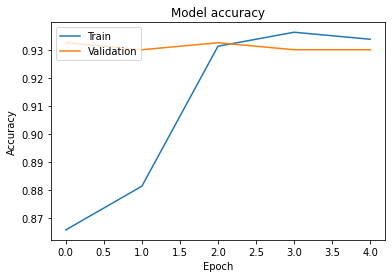

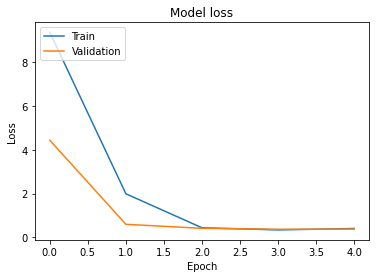

In [46]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [47]:
# Make predictions on the validation set
y_pred = model.predict(X_val_images)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

Accuracy: 0.9325


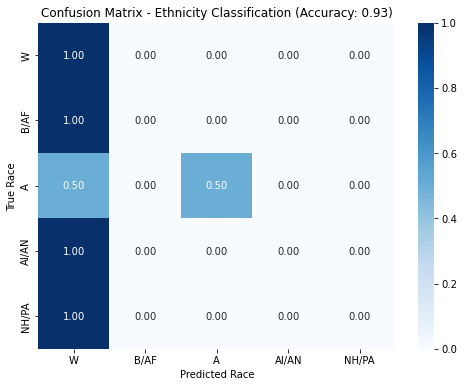

In [48]:
# Create a confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)

cma = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define race labels
race_labels = ['W', 'B/AF', 'A', 'AI/AN', 'NH/PA']

# Calculate accuracy
accuracy = accuracy_score(y_val_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cma, annot=True, fmt='.2f', cmap='Blues', xticklabels=race_labels, yticklabels=race_labels)
plt.xlabel('Predicted Race')
plt.ylabel('True Race')
plt.title(f'Confusion Matrix - Ethnicity Classification (Accuracy: {accuracy:.2f})')
plt.show()